In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pymatgen.ext.matproj import MPRester
from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pandas
from ase import io
import os
from pymatgen.io.ase import AseAtomsAdaptor

import warnings
warnings.filterwarnings("error")


Need to pickle in the data we've gathered from mp


In [2]:
unary_data = pickle.load(open("../data_gather/unary_oxide_data_.p", "rb"))


Exception ignored in: <_io.FileIO name='../data_gather/unary_oxide_data_.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_67886/895738257.py", line 1, in <cell line: 1>


In [3]:
def get_ref_data(element, reference_oxide_id, desired_ox=None):
    found = False
    
    if reference_oxide_id is None:
        # need to retrieve made up formation energy
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_struct = unary_data[element]['structures'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            return ref_form_ene, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 

def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    if ref_oxidation_state not in ox2lowest.keys():
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]

def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)

def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    ox_states_.append(desired_ox_state)
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    minused = np.array(ox_states)-desired_ox_state
    if min(minused)<0 and max(minused)>0:
        # there are points with higher/lower ox states than the desired ox
        # initialise dummy check values
        closest_higher_ox = 10
        closest_lower_ox = -10
        for val in minused:
            if val<0 and val>closest_lower_ox:
                closest_lower_ox = val
            elif val>0 and val<closest_higher_ox:
                closest_higher_ox = val
        closest_lower_ox+=desired_ox_state
        closest_higher_ox+=desired_ox_state
        # need to ensure the key is right
        form_ene1 = energy_dict[round(closest_lower_ox, 3)]
        form_ene2 = energy_dict[round(closest_higher_ox, 3)]
        # get weighted average
        adapted = form_ene1*(abs(closest_higher_ox)/(abs(closest_lower_ox)+abs(closest_higher_ox)))+form_ene2*(abs(closest_lower_ox)/(abs(closest_lower_ox)+abs(closest_higher_ox)))
        return adapted
    
    elif min(minused)<0:
        # trying to get a value for a point which has no info at higher oxidation states        
        sorted_index_array = np.argsort(np.array(ox_states))
        sorted_array = np.array(ox_states)[sorted_index_array]
        # take 2 largest values
        rslt = sorted_array[-2:]
        lower_ox = min(rslt[0], rslt[1])
        higher_ox = max(rslt[0], rslt[1])
        l_ox_ene = energy_dict[lower_ox]
        h_ox_ene = energy_dict[higher_ox]
        # use eq. of line
        m = (h_ox_ene-l_ox_ene)/(higher_ox-lower_ox)
        c = h_ox_ene-m*higher_ox
        y_new = m*desired_ox_state+c
        return y_new

def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])

    coeffs_ = np.polyfit(xs, ys, 2)
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_


def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox

            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
            if ox>6 and reference_element_ not in ['Ru', 'Mo', 'W', 'Re', 'Sb']:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='W' and not ox.is_integer():
                # need to fit through WO3,this allows that
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Te' and ox==4.5:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            else:
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    else:
        for ox in low_ox_state_data:
            if reference_element_=='Ni' and 2.5<ox<3 and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if (reference_element_=='Cu' and (ox!=2)) and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            elif reference_element_=='Fe' and not ox.is_integer() and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_ in ['Ni', 'Ca', 'Mg', 'Pt', 'Pd', 'Cu', 'Ba', 'Cs', 'Rb', 'Yb', 'Zn'] and ref_oxidation_state==4:
                # push to have minimum close to MO
                pairs.append((4, 0.))
            if reference_element_ in ['Dy', 'Tb', 'Tm'] and ref_oxidation_state==4:
                # push to have minimum close to M2O3
                pairs.append((2, 0.))
            if reference_element_=='Na' and ox!=1:
                continue
            if reference_element_ in ['Li','Na'] and ref_oxidation_state==4:
                # push to have minimum close to M2O
                pairs.append((6, 0.))
            if reference_element_ in ['Sm',] and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Pb' and ref_oxidation_state==4 and ox>2:
                # forces to fit through PbO
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Rb' and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2 or (reference_element_=='W' and oxidising):
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
        if not (reference_element_=='W' and oxidising):
            return None
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  needs to be done differently.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{} oxidising".format(reference_element_))
    else:
        plt.title("{} reducing".format(reference_element_))
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull



def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_structure_ = get_ref_data(reference_element_, reference_mpid)
    ref_m_coords, ref_ox_state, ref_o_o_coords, ref_o_m_coords, ref_o_pc = structure_inspection(ref_structure_)
    assert ref_ox_state==ref_oxidation_state
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)

        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        else:
            bool2check = ox_state<ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        # this determines whether to save the entry based on coordinations, if your reference is different
        if bool2check:

            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, _)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, _)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest




Mo_ox
Mo mp-510536 4


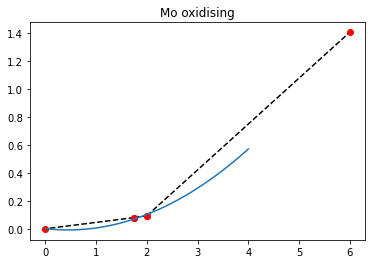

W_ox
W mp-19372 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.


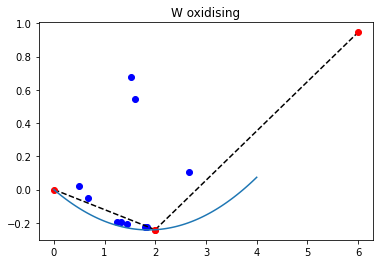

Nb_ox
Nb mp-557057 4


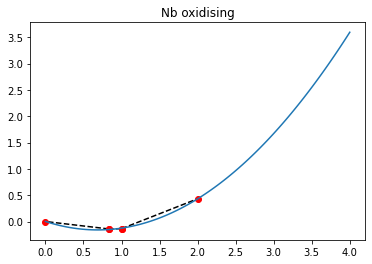

Ni_ox
Ni mp-35925 4


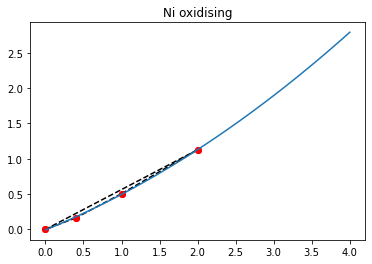

V_ox
V mp-19094 4


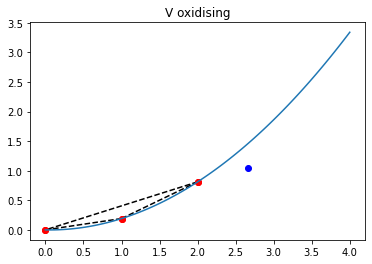

Ir_ox
Ir mp-2723 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ru_ox
Ru mp-825 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cr_ox
Cr mp-19177 4
Fe_ox
Fe mp-1205429 4


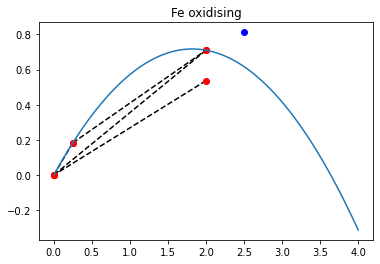

Mn_ox
Mn mp-19395 4


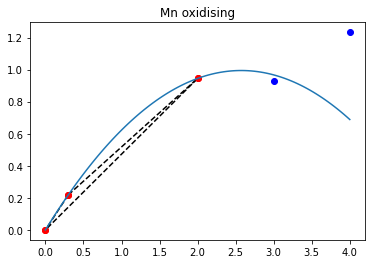

Co_ox
Co mvc-14149 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820165142  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Co  needs to be done differently.


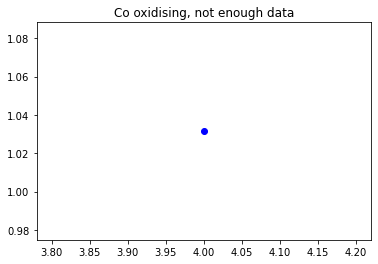

Pb_ox
Pb mp-20725 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sb_ox
Sb mvc-5581 4


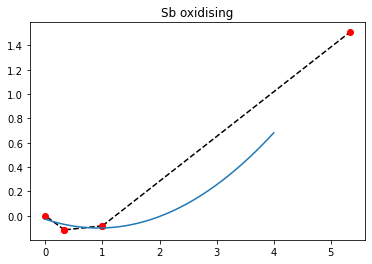

Sn_ox
Sn mp-856 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Bi_ox
Bi mp-557993 4
Ti_ox
Ti mp-390 4
Ta_ox
Ta mp-510 4


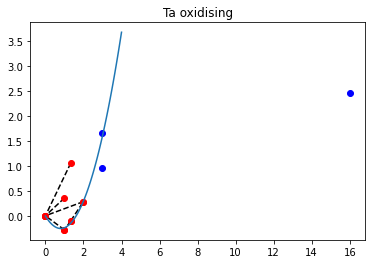

In_ox
In mp-1181008 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pt_ox
Pt mp-1077716 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pd_ox
Pd mp-1018886 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820232370  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Pd  needs to be done differently.


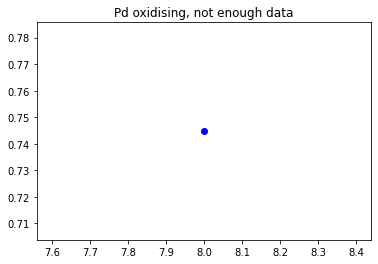

Re_ox
Re mp-12875 4


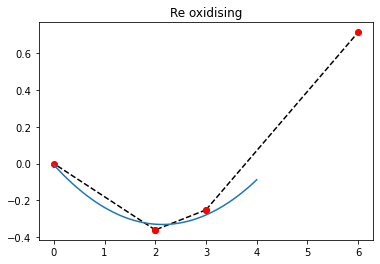

Os_ox
Os mp-996 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820232370  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Os  needs to be done differently.


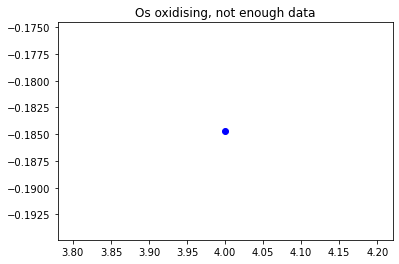

Ge_ox
Ge mp-2633 4
Tc_ox
Tc mp-1205302 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820232370  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tc  needs to be done differently.


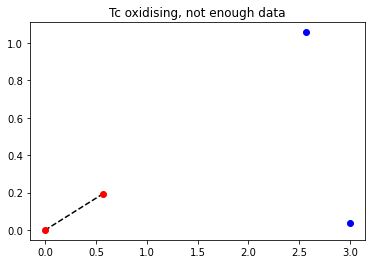

Rh_ox
Rh mp-725 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820232370  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Rh  needs to be done differently.


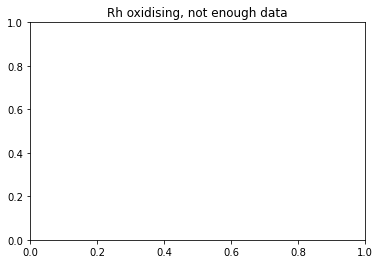

Cu_ox
Cu mp-25378 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820249177  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Cu  needs to be done differently.


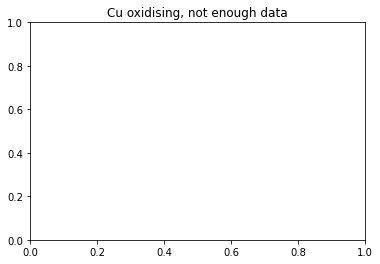

Te_ox
Te mp-2125 4
Li_ox
Li mp-1018789 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Na_ox
Na mp-1901 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ca_ox
Ca mp-634859 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820249177  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ca  needs to be done differently.


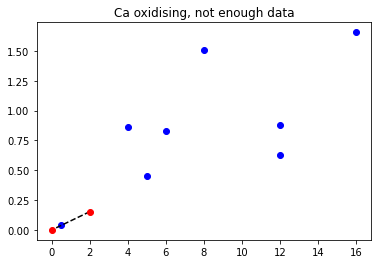

K_ox
K mp-1866 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Rb_ox
Rb mp-12105 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cs_ox
Cs mp-1441 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820265984  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Cs  needs to be done differently.


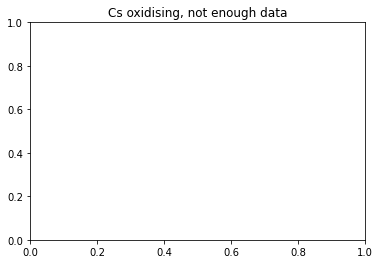

Mg_ox
Mg mp-2589 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820265984  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Mg  needs to be done differently.


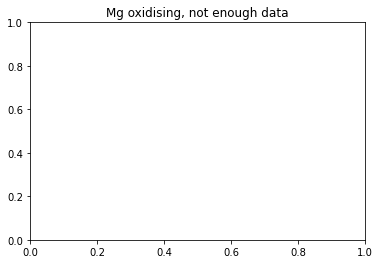

Y_ox
Y mp-1206610 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sc_ox
Sc mp-1179114 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ba_ox
Ba mp-1105 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820282791  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ba  needs to be done differently.


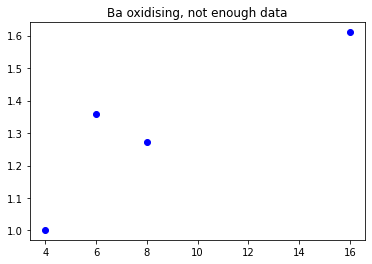

Zn_ox
Zn mp-1094003 4
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820282791  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Zn  needs to be done differently.


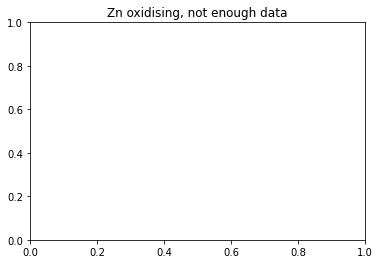

La_ox
La mp-1206559 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ce_ox
Ce mp-20194 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pr_ox
Pr mp-1302 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Nd_ox
Nd mp-31049 4


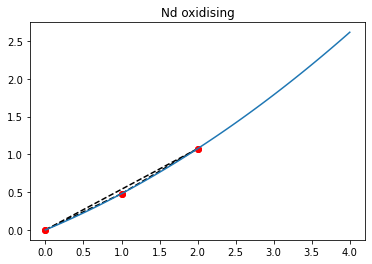

Sm_ox
Sm mp-1077235 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Eu_ox
Eu mp-1018700 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tb_ox
Tb mp-2458 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Dy_ox
Dy mp-1206731 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Er_ox
Er mp-1206338 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tm_ox
Tm mp-1206313 4
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Yb_ox
Yb mp-1178667 4
Mo_red


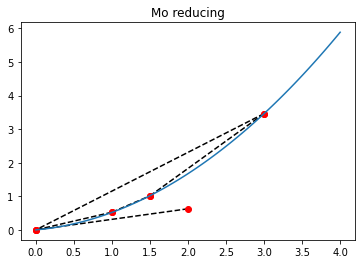

W_red


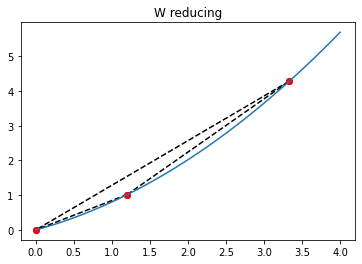

Nb_red


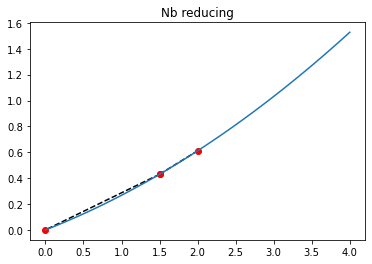

Ni_red


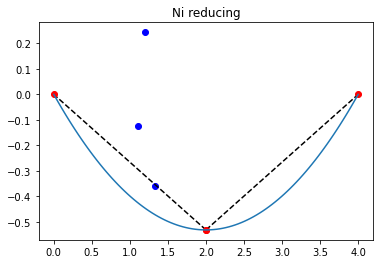

V_red


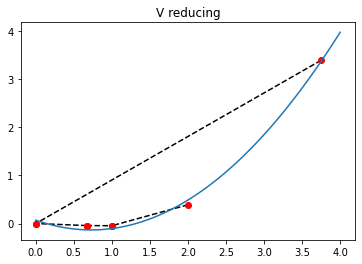

Ir_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820417247  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ir  needs to be done differently.


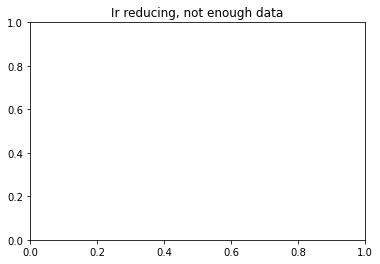

Ru_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820417247  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ru  needs to be done differently.


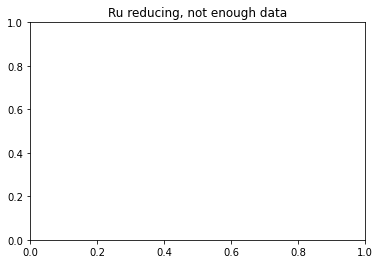

Cr_red


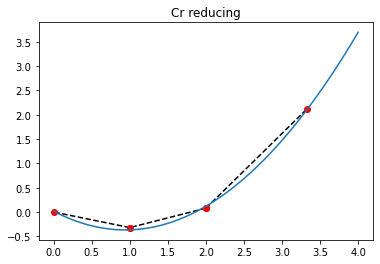

Fe_red


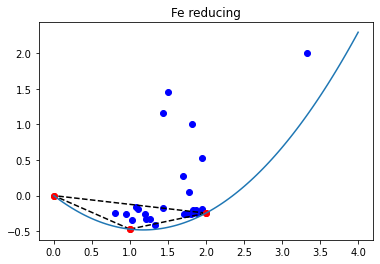

Mn_red


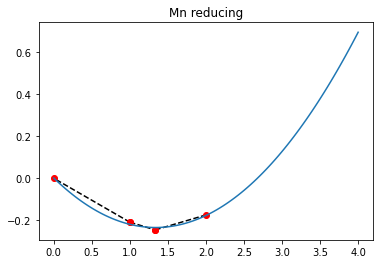

Co_red


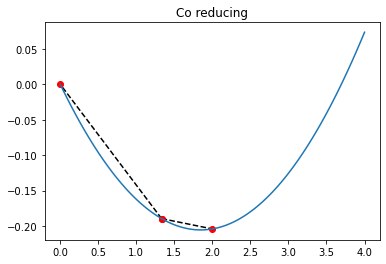

Pb_red


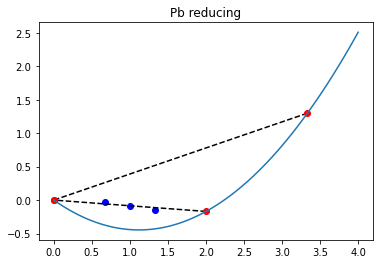

Sb_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sn_red


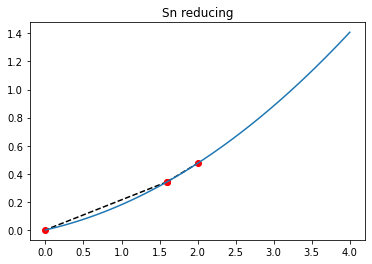

Bi_red


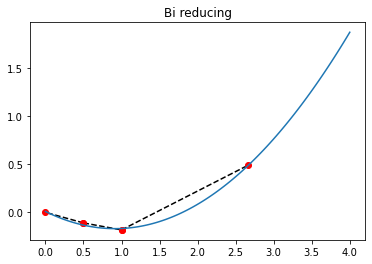

Ti_red


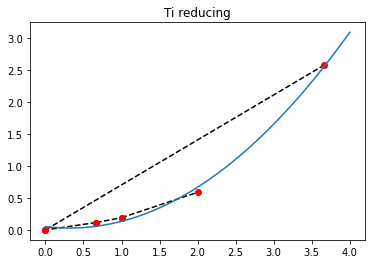

Ta_red


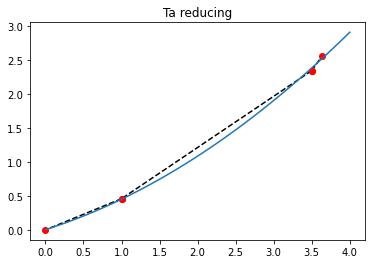

In_red


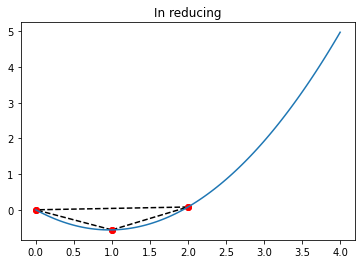

Pt_red
Pd_red


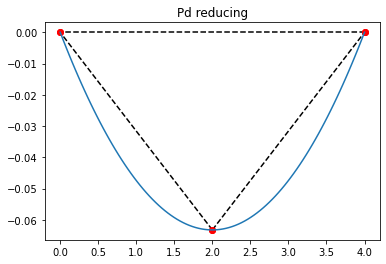

Re_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820551703  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Re  needs to be done differently.


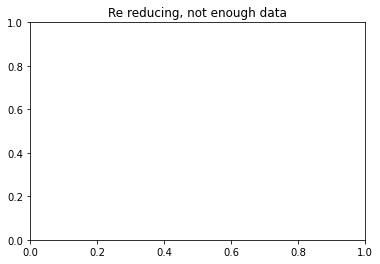

Os_red
Ge_red


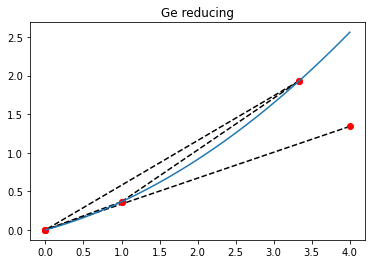

Tc_red
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 820568510  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tc  needs to be done differently.


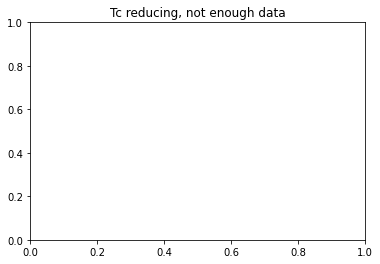

Rh_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Cu_red


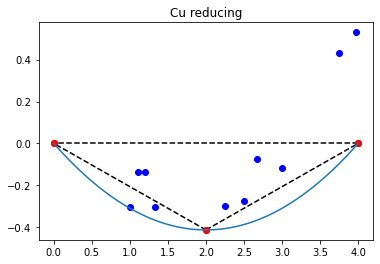

Te_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Li_red


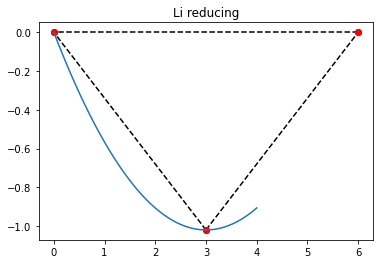

Na_red


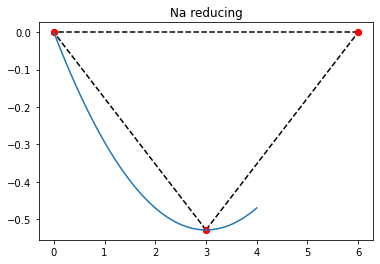

Ca_red


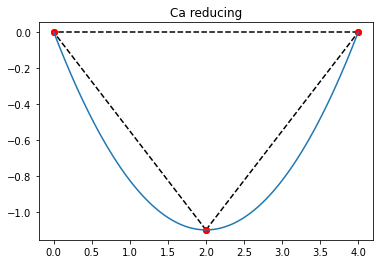

K_red


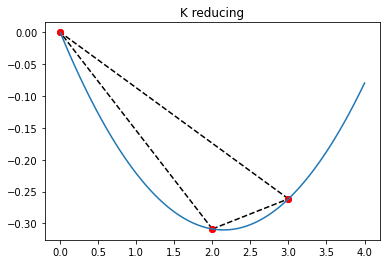

Rb_red


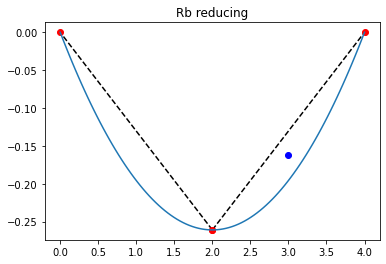

Cs_red


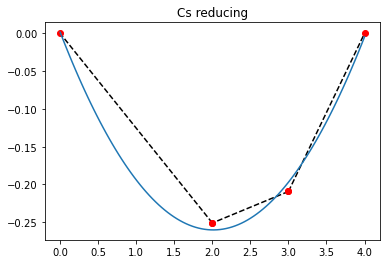

Mg_red


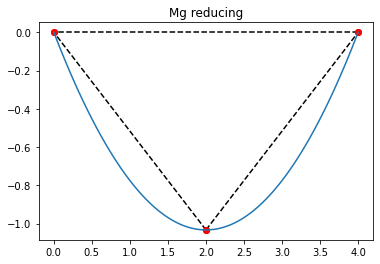

Y_red


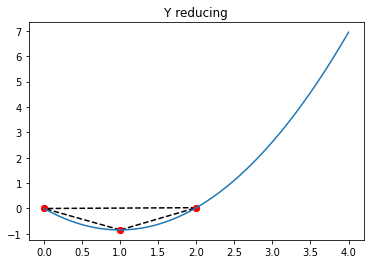

Sc_red


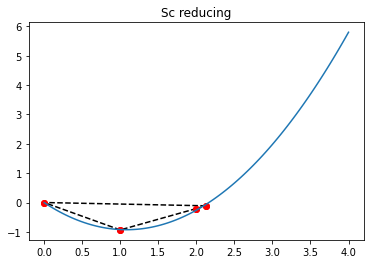

Ba_red


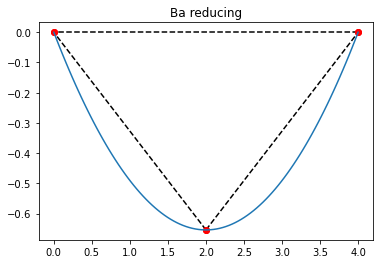

Zn_red


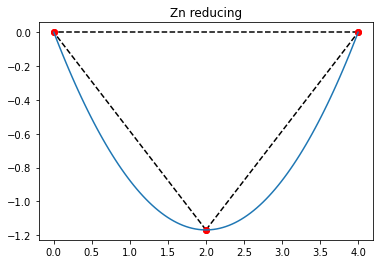

La_red


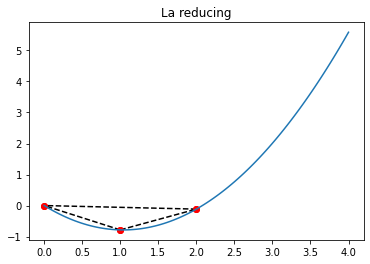

Ce_red


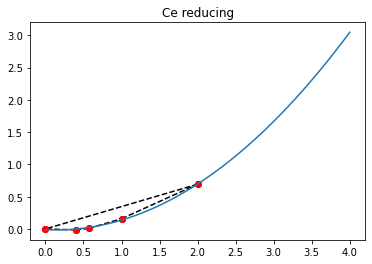

Pr_red


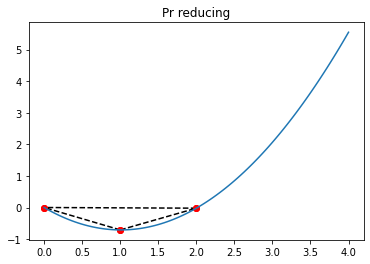

Nd_red


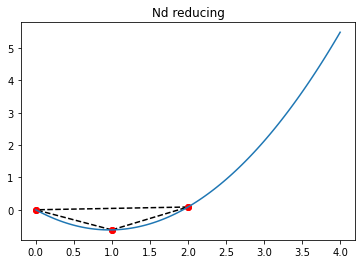

Sm_red


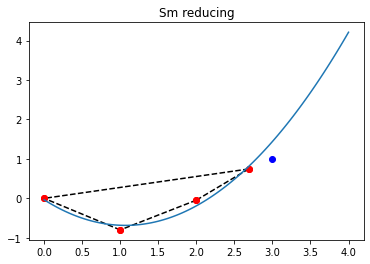

Eu_red


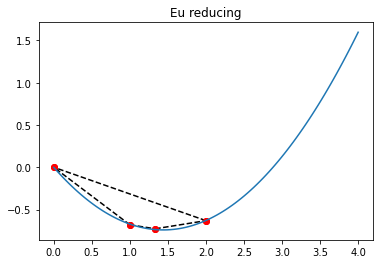

Tb_red


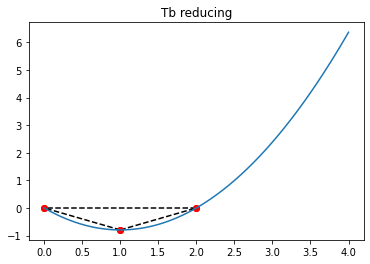

Dy_red


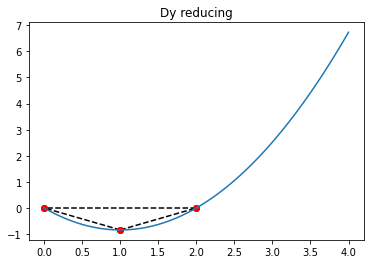

Er_red


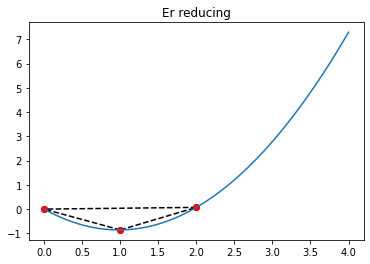

Tm_red


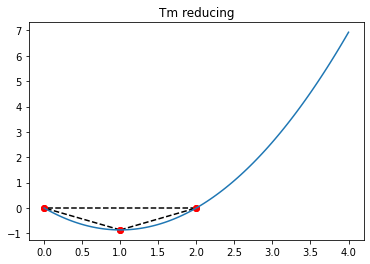

Yb_red


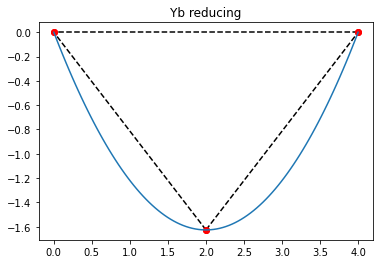

Exception ignored in: <_io.FileIO name='mp_quadratic_equations_ox.p' mode='wb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_67886/1730109064.py", line 94, in <cell line: 94>
Exception ignored in: <_io.FileIO name='mp_quadratic_equations_red.p' mode='wb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_67886/1730109064.py", line 95, in <cell line: 95>


In [4]:
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-557057', # not rutile, 0.03 eV/atom lower
    'Ni': 'mp-35925', # layered Ni
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-1205429', # this is lowest FeO2, suspect rutile in MP is wrong magmoms
    'Mn': 'mp-19395', # many morphologiesi close to eachother, rutile 0.03 eV/atom
    'Co': 'mvc-14149', # layered Co mp-1272749 octahedral
    'Pb': 'mp-20725',
    'Sb': 'mvc-5581',#mp-230 omst stable, # mvc-5581 was chosen since it is 0.17 eV/atom more unstable than the most stable MP SbO2 (this is chosen because OQMD has this difference for its rutile SbO2)
    'Sn': 'mp-856',
    'Bi': 'mp-557993',#mp-557993 not rutile
    'Ti': 'mp-390',
    'Ta': 'mp-510', #mp-20994 rutile, 0.02 eV/atom higher
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',# not rutile
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
    'Cu': 'mp-25378',
    'Te': 'mp-2125', # mp-2237 rutile, 0.25 eV/atom higher, icsd
    'Li': 'mp-1018789',
    'Na': 'mp-1901',
    'Ca': 'mp-634859',
    'K': 'mp-1866',
    'Rb': 'mp-12105',
    'Cs': 'mp-1441',
    'Mg': 'mp-2589',
    'Y': 'mp-1206610',
    'Sc': 'mp-1179114',
    'Ba': 'mp-1105',
    'Zn': 'mp-1094003',
    'La': 'mp-1206559',
    'Ce': 'mp-20194',
    'Pr': 'mp-1302',
    'Nd': 'mp-31049',
    'Sm': 'mp-1077235',
    'Eu': 'mp-1018700',
    'Tb': 'mp-2458',
    'Dy': 'mp-1206731',
    #'Ho': 'mp-1206243',
    'Er': 'mp-1206338',
    'Tm': 'mp-1206313',
    'Yb': 'mp-1178667'
}

ox_state = 4
mp_quadratic_equations_ox = defaultdict()

for ele in ele2mp:
    print("{}_ox".format(ele))
    print(ele, ele2mp[ele], ox_state)
    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=True)
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=True)
    if hull_ox2energy is None:
        ref_ene, _ = get_ref_data(ele, ele2mp[ele])
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        mp_quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
        continue
    if len(hull_ox2energy.keys())==2:
        key = [x for x in hull_ox2energy.keys() if x!=0][0]
        mp_quadratic_equations_ox[ele] = [0, hull_ox2energy[key]/key,0]
        continue

    coeffs = get_quadratic(hull_ox2energy)
    mp_quadratic_equations_ox[ele] = coeffs
    
mp_quadratic_equations_red = defaultdict()
for ele in ele2mp:
    print("{}_red".format(ele))
    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=False)
        
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=False)
    if hull_ox2energy is None:
        ref_ene, _ = get_ref_data(ele, ele2mp[ele])
        mp_quadratic_equations_red[ele] = [0, -form_ene/4, 0]
        continue
    if len(hull_ox2energy.keys())==2:
        key = [x for x in hull_ox2energy.keys() if x!=0][0]
        mp_quadratic_equations_red[ele] = [0, hull_ox2energy[key]/key,0]
        continue
    
    coeffs = get_quadratic(hull_ox2energy)
    mp_quadratic_equations_red[ele] = coeffs

pickle.dump(mp_quadratic_equations_ox, open("mp_quadratic_equations_ox.p", "wb"))
pickle.dump(mp_quadratic_equations_red, open("mp_quadratic_equations_red.p", "wb"))

    
